In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import imodelsx.process_results
import pickle as pkl
import viz
import sys
import notebook_helper
from matplotlib.backends.backend_pdf import PdfPages
sys.path.append('../experiments/')
# results_dir = '/home/chansingh/mntv1/tree-prompt/feb25'
results_dir = '/home/chansingh/mntv1/tree-prompt/mar17'

r = imodelsx.process_results.get_results_df(results_dir)

# fill missing args with default values from argparse
experiment_filename = '../experiments/01_fit.py'
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename)
r['mean_llm_calls'] = notebook_helper.add_mean_llm_calls(r)


# filter
# r[r['verbalizer_num'] == 0]

# group using these experiment hyperparams when averaging over random seeds
group_keys = [
    k for k in imodelsx.process_results.get_main_args_list(experiment_filename)
    if not k == 'seed'
]
ravg = (
    r
    .groupby(by=group_keys)
    .mean(numeric_only=True)
    .reset_index()
)

# display all rows
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(
#         ravg
#         .sort_values(by=['dataset_name', 'model_name', 'num_prompts'], ascending=True)
#         .reset_index()
#         [['dataset_name', 'model_name', 'num_prompts', 'prompt_source', 'verbalizer_num', 'roc_auc_test']]
#         .round(3)
#     )

100%|██████████| 75/75 [00:05<00:00, 12.97it/s]


In [7]:
import imodelsx.data
X_train_text, X_test_text, y_train, y_test = imodelsx.data.load_huggingface_dataset(
    dataset_name='imdb',
    # subsample_frac=args.subsample_frac,
    return_lists=True,
    binary_classification=True,
)

  0%|          | 0/3 [00:00<?, ?it/s]

[autoreload of 01_fit failed: Traceback (most recent call last):
  File "/home/chansingh/.llm/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/chansingh/.llm/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/usr/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/chansingh/tree-prompt/experiments/01_fit.py", line 182
    X_train, X_test, feature_names = \
    ^
IndentationError: expected an indented block
]


(array([    0.,     0.,     0.,     0.,     0., 25000.,     0.,     0.,
            0.,     0.]),
 array([14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2, 15.3, 15.4, 15.5]),
 <BarContainer object of 10 artists>)

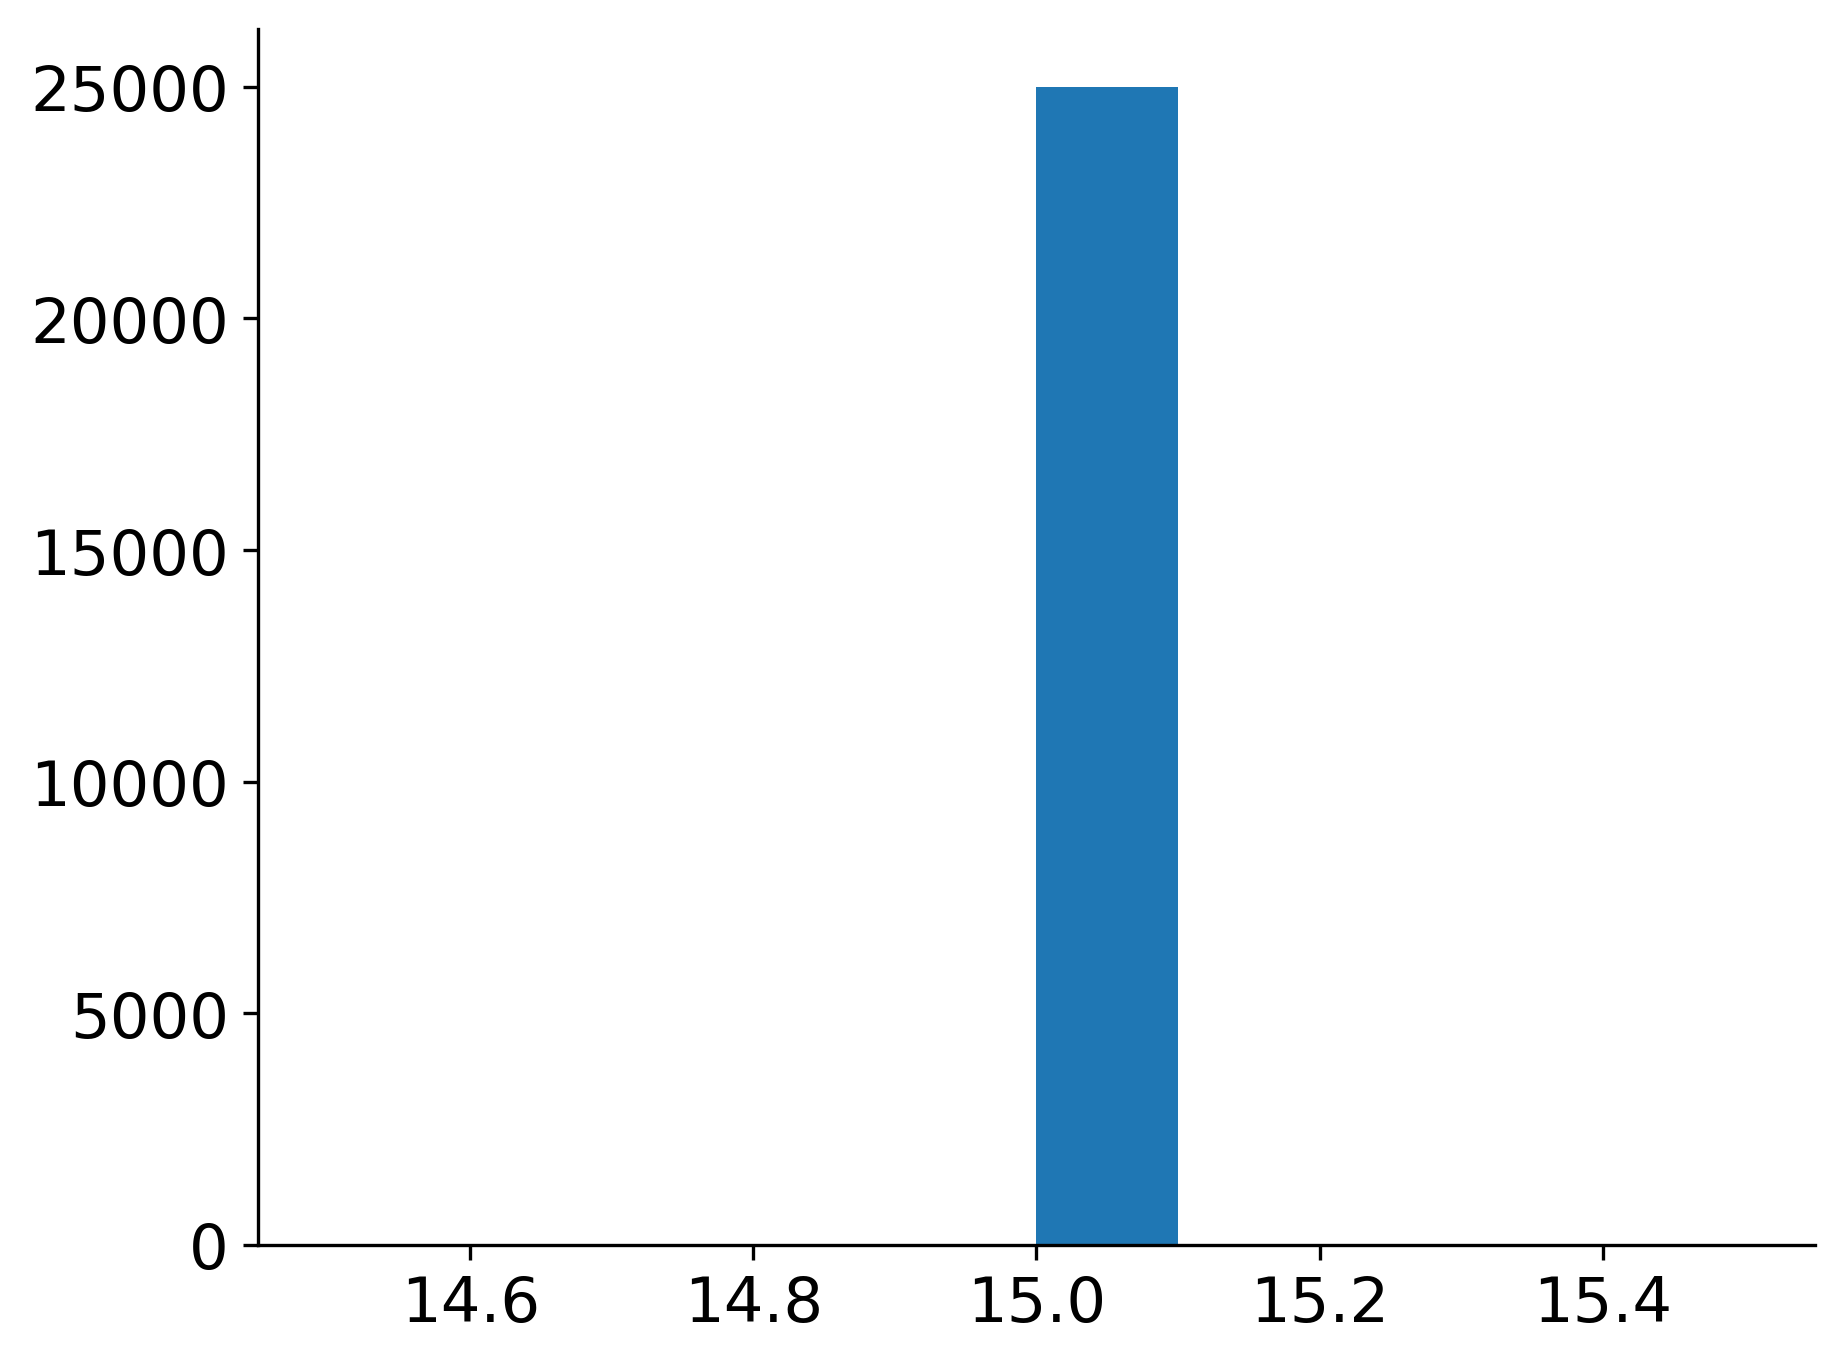

In [9]:
plt.hist([len(x[:15]) for x in X_train_text])

In [ ]:
for checkpoint in r['checkpoint'].unique():
    for prompt_source in r['prompt_source'].unique():
        for verbalizer_num in r['verbalizer_num'].unique():

            rcurve = ravg[ravg.checkpoint == checkpoint]
            rcurve = rcurve[rcurve.prompt_source == prompt_source]
            rcurve = rcurve[rcurve.verbalizer_num == verbalizer_num]
            if len(rcurve) > 0:
                rcurve = rcurve.sort_values(by=['dataset_name', 'model_name', 'mean_llm_calls'])

                groupings = ['model_name', 'max_features', 'ngrams',
                            'refinement_strategy', 'use_llm_prompt_context', 'use_stemming']
                metric = 'roc_auc'
                # metric = 'accuracy'
                x = 'mean_llm_calls'
                # x = 'num_prompts'

                viz.plot_perf_curves_individual(rcurve, x=x)
                plt.suptitle(f'checkpoint {checkpoint} prompt_source {prompt_source} verb {verbalizer_num}', fontsize='xx-small')
                # plt.suptitle(f'{prompt_source} prompts', fontsize='x-small')
                # plt.show()
                # plt.tight_layout()
                # plt.show()

# viz.save_figs_to_single_pdf("all_results.pdf")

### Apply cross-validation

In [ ]:
# apply cross validation
ravg_cv = (
    ravg
    .sort_values(by='accuracy_cv', ascending=False)
    .groupby(by=['split_strategy', 'dataset_name'])
    .first()
    .reset_index()
)
ravg_cv

In [ ]:
sns.barplot(data=ravg_cv, x='model_name', y='accuracy_test') #, hue='dataset_name')
plt.show()

Load an individual model

In [ ]:
run_args = r[r.model_name == 'manual_tree'].iloc[0]
model = pkl.load(open(join(run_args.save_dir_unique, 'model.pkl'), 'rb'))
model